<center><img src='../../img/ai4eo_logos.jpg' alt='Logos AI4EO MOOC' width='80%'></img></center>

<hr>

<br>

<a href="https://www.futurelearn.com/courses/artificial-intelligence-for-earth-monitoring/1/steps/1170987"><< Back to FutureLearn</a><br>

# Training of a sequential neural network for soil moisture prediction

<i>by Leonardo De Laurentiis, University of Tor Vergata, Rome, Italy</i>

<hr>

## Watch the video tutorial

In [1]:
from IPython.display import HTML
HTML('<div align="center"><iframe src="https://player.vimeo.com/video/510225048" width="640" height="360" frameborder="0" allow="autoplay; fullscreen; picture-in-picture" allowfullscreen align="middle"></iframe></div>')     

<br>

<hr>

## Introduction

This workflow will guide you through the different steps to train a `sequential neural network model` in order to predict soil moisture based on SAR backscatter and incidence angle information. The model is trained based on VH and VV backscatter information retrieved from an implementation of the [Integral Equation Model modified by Baghdadi (IEM-B)](https://www.mdpi.com/2073-4441/9/1/38).

The IEM-B is a well-known inversion model which can simulate the backscattering and polarisation of SAR data based on ground-truth soil moisture values. The input data to the model were soil moisture values from the [International Soil Moisture Network (ISMN)](https://hess.copernicus.org/preprints/hess-2021-2/) and SAR incidence angles from 30 to 32.

The `sequential neural network` learns how to invert from SAR backscatter and incidence angle information to predict soil moisture content. Backscatter and incidence angle information from a Sentinel-1 image and the associated soil moisture value from an ISMN station near Bordeaux, France (44.789900 N, -0.576500 W) serve for model validation.


## Machine-Learning Algorithm

The workflow trains a [sequential neural network with Keras](https://keras.io/api/models/sequential/), which is a linear stack of layers. There are two ways to build Keras models:
* in a `sequential` way and
* a `functional` way.

The `sequential` API allows you to create models in a sequential way, which means you add one layer after the other. A sequential model is applicable for most problems. Limitations of `sequential` models are that they do not allow you to create models that share layers or that have multiple inputs or outputs.

## Data

This workflow makes use of the .txt file [MOOC_IEM_Data](./MOOC_IEM_Data.txt). The file contains of a total of 268 rows and four columns. The first 264 rows contain the IEM-B model outputs (`VV- and VH-backscatter` values) of a sequence of `soil moisture values` ranging from 0.01 to 0.81 with a step of 0.025 and associated `incidence angles` ([30,32]). The first 264 rows are used to train the sequential model. 

The last four rows contain `VV- and VH-backscatter values, incidence angles` from Sentinel-1 images and associated measured `soil moisture values` from a location near Bordeaux, France ((44.789900 N, -0.576500 W) taken from the International Soil Moisture Network (ISMN).

The columns are as follows: 
* Column 1 - `SAR VH backscattering values in dB`
* Column 2 - `SAR VV backscattering values in dB`
* Column 3 - `incidence angles in degrees`
* Column 4 - `volumetric soil moisture content`

## Further resources

* [Evaluation of the Oh, Dubois and IEM Backscatter Models Using a Large Dataset of SAR Data and Experimental Soil Measurements](https://www.mdpi.com/2073-4441/9/1/38)
* [International Soil Moisture Network (ISMN)](https://hess.copernicus.org/preprints/hess-2021-2/)

<hr>

## Notebook outline
* [1 - Load and prepare the input and output data for model training](#load_prepare)
* [2 - Define and compile a sequential neural network model with Keras](#define_seq_model)
* [3 - Training (fitting) of the sequential model](#sequential_fitting)
* [4 - Evaluate model performance](#model_evaluation)
* [5 - Predicting soil moisture with the trained sequential neural network](#soil_moisture_prediction)

<hr>

#### Import libraries

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.optimizers import SGD

from sklearn import preprocessing

from matplotlib import pyplot
import datetime

import numpy as np
import scipy
import os

<hr>

<br>

## <a id='load_prepare'></a>1. Load and prepare the input and output data for model training

The first step is to load the .txt file [MOOC_IEM_DATA.txt](./MOOC_IEM_DATA.txt). The file contains 268 rows and four columns. Each row contains a different sample. The dataset contains `SAR VH backscatter in dB`, `SAR VV backscatter in dB`, `incidence angle in degrees` and `volumetric soil moisture content`. The first 264 rows indicate the IEM-B model outputs, while the last four rows hold information from Sentinel-1 images and soil moisture values from a station of the ISMN.

With the numpy function `loadtxt`, you can load a text file, by indicating the delimiter used in the file.


In [2]:
dataset = np.loadtxt('./MOOC_IEM_Data.txt', delimiter=',')
dataset

array([[-1.11440881e+02, -3.64672855e+01,  3.00000000e+01,
         1.00000000e-02],
       [-8.76129310e+01, -2.36669363e+01,  3.00000000e+01,
         3.50000000e-02],
       [-8.15197821e+01, -2.01477266e+01,  3.00000000e+01,
         6.00000000e-02],
       ...,
       [-1.93148527e+01, -1.36881897e+01,  3.03145447e+01,
         1.53400000e-01],
       [-1.65789782e+01, -1.33898071e+01,  3.03364582e+01,
         1.13900000e-01],
       [-2.01774177e+01, -1.21917423e+01,  4.05743599e+01,
         1.06000000e-01]])

<br>

We split the loaded dataset in `input (X)` and `output (y)` variables. From the dataset file, the first three columns (`SAR VH backscattering values in dB`, `SAR VV backscattering values in dB` and `incidence angle in degrees`) serve as input (X) values.

The fourth column of the dataset file contains values of `volumetric soil moisture content`, which serve as output (y) variables.


In [3]:
X = dataset[:, 0:3]
y = dataset[:, 3]

X, y

(array([[-1.11440881e+02, -3.64672855e+01,  3.00000000e+01],
        [-8.76129310e+01, -2.36669363e+01,  3.00000000e+01],
        [-8.15197821e+01, -2.01477266e+01,  3.00000000e+01],
        [-7.83381680e+01, -1.82439517e+01,  3.00000000e+01],
        [-7.62944843e+01, -1.69926284e+01,  3.00000000e+01],
        [-7.48347295e+01, -1.60838488e+01,  3.00000000e+01],
        [-7.37214435e+01, -1.53818334e+01,  3.00000000e+01],
        [-7.28334817e+01, -1.48161135e+01,  3.00000000e+01],
        [-7.21016652e+01, -1.43458828e+01,  3.00000000e+01],
        [-7.14832120e+01, -1.39456095e+01,  3.00000000e+01],
        [-7.09500391e+01, -1.35983659e+01,  3.00000000e+01],
        [-7.04828348e+01, -1.32924097e+01,  3.00000000e+01],
        [-7.00678137e+01, -1.30192944e+01,  3.00000000e+01],
        [-6.96948291e+01, -1.27727596e+01,  3.00000000e+01],
        [-6.93562188e+01, -1.25480485e+01,  3.00000000e+01],
        [-6.90460719e+01, -1.23414705e+01,  3.00000000e+01],
        [-6.87597487e+01

<br>

### <a id='normalisation_sm'></a>Normalisation of input variables

`(Feature) Normalisation` is a technique often applied in Machine Learning. The goal of normalisation is to change the values of the numeric columns to a common scale, without distorting differences in the ranges of values. For Machine Learning, not every dataset requires normalisation. It is only required when features have different ranges or units. This is the case with the present input data, which are `VV backscatters (in dB)`, `VH backscatters (in dB)` and `incidence angles in degrees`.

Scikitlearn's preprocessing library offers the function `minmax_scale()`, which normalizes the input values to a range from 0 to 1. This normalisation process is known as `unity-based normalisation` and is a very common normalisation process in Machine Learning.

The normalised values range then from 0 to 1.


In [4]:
preprocessed_X = preprocessing.minmax_scale(X, feature_range=(0, 1))
preprocessed_X

array([[0.00255986, 0.00343881, 0.        ],
       [0.25302696, 0.34440281, 0.        ],
       [0.31707499, 0.4381443 , 0.        ],
       [0.35051847, 0.48885532, 0.        ],
       [0.37200062, 0.52218692, 0.        ],
       [0.38734481, 0.54639416, 0.        ],
       [0.39904709, 0.56509381, 0.        ],
       [0.40838089, 0.58016293, 0.        ],
       [0.41607337, 0.59268851, 0.        ],
       [0.42257423, 0.60335062, 0.        ],
       [0.42817866, 0.61260018, 0.        ],
       [0.43308967, 0.62074996, 0.        ],
       [0.43745216, 0.62802496, 0.        ],
       [0.44137278, 0.63459193, 0.        ],
       [0.44493208, 0.64057758, 0.        ],
       [0.44819218, 0.64608021, 0.        ],
       [0.45120187, 0.6511774 , 0.        ],
       [0.45399992, 0.65593113, 0.        ],
       [0.45661742, 0.66039124, 0.        ],
       [0.45907924, 0.66459774, 0.        ],
       [0.46140493, 0.66858207, 0.        ],
       [0.46360917, 0.67236773, 0.        ],
       [0.

<br>

### <a id='split_training_test'></a>Split input data into training and test data

In the next step, you want to split the input data into training and test data. 

As a first step, let us define a variable called `iem_samples` which holds the number of `integral equation model (IEM)` samples (264). This variable helps you to split the input (X) data into training and test data.

In [5]:
iem_samples = dataset.shape[0]-4
iem_samples


264

With the variable defined in the previous step, you can split the normalised input (X) and output (y) data into training and test samples. You want to use the 264 IEM_B samples for training and the four samples based on Sentinel-1 images as test data.

In [6]:
test_X_S1 = preprocessed_X[iem_samples:]
preprocessed_X_iem = preprocessed_X[:iem_samples]

test_y_S1 = y[iem_samples:]
y_iem = y[:iem_samples]

<br>

In a next step, you want to `random shuffle` the data. By `random shuffling` the data, you de-correlate potential correlation or a human-induced ordering of the input (X) and output (y) data.

In order to random shuffle the data, you first create a list of integers with 264 entries with `np.arange()`, indicating the index values of a Python list. Then, you randomly shuffle the list of index values with `np.random.shuffle()`.

The randomly shuffled list of index values can then be applied to the training input (`preprocessed_X_iem`) and training output (`y_iem`) data.

In [7]:
s = np.arange(iem_samples)
np.random.shuffle(s)
preprocessed_X_shuffled = preprocessed_X_iem[s]
y_shuffled = y_iem[s]

<br>

### <a id='split_2'></a>Split training data into training and test data 

The next step splits the training data into two subsets: 
* `train_X` / `train_y` --> 70% of the training data
* `test_X` / `test_y` --> 30% of the training data. 

The first 185 entries (70% of 264) are used for training the model and the remaining data are used for testing. You generate training and testing subsets originating from `preprocessed_X_shuffled` (input) and `y_shuffled` (output) data.

In [8]:
n_train_perc = 0.7
n_train = round(preprocessed_X_shuffled.shape[0] * n_train_perc)
n_train

185

In [9]:
train_X  = preprocessed_X_shuffled[:n_train, :]
train_y  = y_shuffled[:n_train] 

test_X = preprocessed_X_shuffled[n_train:, :]
test_y = y_shuffled[n_train:]

n_train, train_X, test_X

(185,
 array([[0.67277204, 0.87224721, 0.18913674],
        [0.64405314, 0.87145495, 0.        ],
        [0.682906  , 0.87825149, 0.        ],
        [0.68351695, 0.89037274, 0.18913674],
        [0.62179464, 0.83812209, 0.18913674],
        [0.71500288, 0.93385958, 0.18913674],
        [0.60015484, 0.80117523, 0.18913674],
        [0.6634962 , 0.85679125, 0.18913674],
        [0.41579728, 0.51710278, 0.18913674],
        [0.46690926, 0.68239806, 0.18913674],
        [0.70059256, 0.91409959, 0.        ],
        [0.61319919, 0.81851774, 0.        ],
        [0.25041455, 0.3415352 , 0.18913674],
        [0.60993913, 0.81303153, 0.        ],
        [0.68517593, 0.88799926, 0.        ],
        [0.23799831, 0.2515075 , 0.18913674],
        [0.72182566, 0.94531959, 0.18913674],
        [0.40569832, 0.57862953, 0.18913674],
        [0.31443038, 0.43562317, 0.18913674],
        [0.70667311, 0.93028218, 0.18913674],
        [0.6726747 , 0.8649356 , 0.18913674],
        [0.66840825, 0.86495

<br>

## <a id='define_seq_model'></a>2. Define and compile a sequential neural network model with Keras

Now you can start defining the sequential neural network model with `keras.Sequential()`.

In [10]:
model = keras.Sequential()

The next step is to add a defined number of layers to the sequential model. The procedure is to define three `dense layers`:
* Layer 1: `dense layer` with 8 neurons and 3 input dimensions, because the input data has three variables
* Layer 2: `dense layer` with 3 neurons
* Layer 3: `dense layer` with 1 neuron, because we want to have one output, soil moisture

Between the layers, we provide the network with `non-linear properties` by applying an activation function, e.g. `LeakyReLU` or `sigmod` to each layer.

In [11]:
# Layer 1
model.add(Dense(8, input_dim=3))
model.add(LeakyReLU(alpha=0.1))

# Layer 2
model.add(Dense(3))
model.add(LeakyReLU(alpha=0.1))

# Layer 3
model.add(Dense(1, activation='sigmoid'))

<br>

Once the model is defined, you can compile (configure) the model with `model.compile()` and you can define the following hyperparameters:
* `loss='mean_absolute_error'` - MAE is one of many loss options and calculates the distance to the output values which is used to minimize the coefficients
* `optimizer=SGD(lr=0.01, momentum=0.9)` - Optimizers are algorithms the network learns from and SGD stands for gradient descent optimizer
* `metrics=['mse']` - is used to evaluate how the model is performing

<br>

**Note related to optimizers:**<br>
*During the learning process the network is performing a forward pass which provides the network with an amount to which the coefficients shall be corrected - lr=learning rate. Learning rate and momentum are hyperparameters that can be changed*


In [12]:
model.compile(loss='mean_absolute_error', 
              optimizer=SGD(lr=0.01, momentum=0.9), 
              metrics=['mse'])

<br>

## <a id='sequential_fitting'></a>3. Training (Fitting) of the sequential model



Now, the data is prepared and the model has been initiated and compiled. The next step is now to train (fit) the model with the defined training data. Before you can start with the model training, it is helpful to define some callbacks that are useful to track model performance and outcomes.

We define three callbacks: (i) a `tensorboard`, (ii) an `EarlyStopping` and (iii) a `ModelCheckpoint`.

Defining a `tensorboard` is optional, but it is a Tensorflow framework that enables you to easily visualize specific model metrics. You can create a tensorboard with `keras.callbacks.TensorBoard()`.

In [13]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

<br>

Another useful `callback` metric may be `EarlyStopping`, which stops the training if the validation loss (`val_loss`) reaches a minimum (`min`), but waits (`patience`) for 50 epochs.
You can define an `EarlyStopping` callback with `keras.callbacks.EarlyStopping()`.

In [14]:
es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)

<br>

Another common callback used is `ModelCheckpoint`, which safes the keras model. During training the `Validation Mean-Squared-Error (MSE)` is monitored and if it reaches a minimum, the model is safed and only the best model fit is kept.

You can define a `ModelCheckpoint` callback with `keras.callbacks.ModelCheckpoint()`.

In [16]:
mc = keras.callbacks.ModelCheckpoint('best_model.h5', monitor='val_mse', mode='min', verbose=1, save_best_only=True)

<br>

The three callbacks can now be used during the training (fitting) process of the model.
You can train (fit) a model in Keras with `model.fit()` and you need to specify the following parameters:
* `input (X)` and `output (y)` data: here specify the input and output data of your model
* `validation_data`: here we enter the test data subsets test_X and test_y and our model outputs are validated against these validation data after each epoch (training cycle)
* `epochs`: number of training cycles
* `batch_size`: defines the size of a training data subset (e.g. 10 samples) after which the weights of the network are updated
* `callbacks`: define here the callbacks you would like to make use of during the training process

**Note:**<br>
*The process where the weights are updated based on the batch_size is also called 'gradient update'.*

The output of the training process is a `history` object and for this reason, the output object has the name `history`.

In [17]:
history = model.fit(train_X, train_y, 
                    validation_data=(test_X, test_y), 
                    epochs=100, 
                    batch_size=10,
                    callbacks=[tensorboard_callback, es, mc])
history

Epoch 1/100
19/19 [==============================] - 3s 67ms/step - loss: 0.2565 - mse: 0.0920 - val_loss: 0.2137 - val_mse: 0.0620

Epoch 00001: val_mse improved from inf to 0.06197, saving model to best_model.h5
Epoch 2/100
19/19 [==============================] - 0s 13ms/step - loss: 0.2079 - mse: 0.0594 - val_loss: 0.2132 - val_mse: 0.0601

Epoch 00002: val_mse improved from 0.06197 to 0.06009, saving model to best_model.h5
Epoch 3/100
19/19 [==============================] - 0s 13ms/step - loss: 0.2178 - mse: 0.0613 - val_loss: 0.2135 - val_mse: 0.0602

Epoch 00003: val_mse did not improve from 0.06009
Epoch 4/100
19/19 [==============================] - 0s 14ms/step - loss: 0.2124 - mse: 0.0585 - val_loss: 0.2141 - val_mse: 0.0605

Epoch 00004: val_mse did not improve from 0.06009
Epoch 5/100
19/19 [==============================] - 0s 13ms/step - loss: 0.1914 - mse: 0.0500 - val_loss: 0.2150 - val_mse: 0.0610

Epoch 00005: val_mse did not improve from 0.06009
Epoch 6/100
19/19 [

<br>

## <a id='model_evaluation'></a>4. Evaluate model performance

After the training process, you want to evaluate the performance of the model. Since we defined the `ModelCheckpoint` callback, you can load the output of the `ModelCheckPoint` with `keras.models.load_model()`. Note that the output is different to the `history` object during model training.

In [18]:
model = keras.models.load_model('./best_model.h5')
model

<br>

With `model.evaluate()` you can evaluate the model predictions based on the test data subsets for X (`test_X`) and y (`test_y`) we have created before. The output returns the mean-squared-error (MSE) between predictions and test data. The aim is to optimize (minimize) the `MSE`

In [19]:
_, test_mse = model.evaluate(test_X, test_y)

print('Mse: %.4f' % test_mse)

3/3 [==============================] - 0s 5ms/step - loss: 0.1881 - mse: 0.0469
Mse: 0.0469


<br>

Another useful evaluation is to plot the `loss` and `validation_loss` metrics during training:
* `loss`: mean absolute error during training (blue line)
* `validation_loss`: mean absolute error while validating the training outputs with test data (orange line)

Both lines (blue and orange) show a decreasing trend during the training process, which indicates a successful training process. The decreasing trend of the orange line shows also that the model is capable of decreasing the mean absolute error when validated with test data.

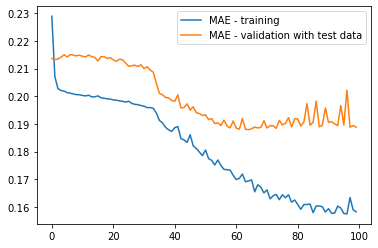

In [20]:
pyplot.plot(history.history['loss'], label='MAE - training')
pyplot.plot(history.history['val_loss'], label='MAE - validation with test data')
pyplot.legend()

<br>

## <a id='soil_moisture_prediction'></a>5. Predicting soil moisture with the trained sequential neural network

As a final step, you can now use the trained sequential neural network and predict soil moisture, based on the test input `test_X_S1`, which has `SAR VH and VV backscattering values in db` and `incidence angle in degrees` of four Sentinel-1 samples.

The code below goes through the four samples of the test input variable and based on the trained model, predicts the soil moisture based on the Sentinel-1 samples. The prediction is done with the function `model.predict()`. The predicted soil moisture values are stored in a list (`predicted`).

At the end, the input and output soil moisture values are printed together with the predicted soil moisture.



In [21]:
predicted = []
for index, value in enumerate(test_X_S1):
    pred = np.expand_dims(value, axis=0)
    predicted.append(model.predict(pred))
    
    print("Input values: " + str(value) + ",  Output soil moisture: " + str(test_y_S1[index]))
    print("Predicted soil moisture: " + str(model.predict(pred)) + "\n ")


Input values: [1.         0.78706989 0.02841644],  Output soil moisture: 0.0848
Predicted soil moisture: [[0.4584852]]
 
Input values: [0.97094106 0.61020754 0.02974598],  Output soil moisture: 0.1534
Predicted soil moisture: [[0.34718686]]
 
Input values: [0.99969916 0.61815558 0.0318183 ],  Output soil moisture: 0.1139
Predicted soil moisture: [[0.35440984]]
 
Input values: [0.96187422 0.65006854 1.        ],  Output soil moisture: 0.106
Predicted soil moisture: [[0.47349933]]
 


<br>

## <a id='evaluate_soil_moisutre_pred'></a> Evaluate model predictions

A common tool to evaluate the accuracy of predicted values versus validation values is the visualisation of both as a scatter plot. Such a scatter plot shows the `original vs the predicted` soil moisture values as scatters. It a great graphical representation showing whether the trained sequential neural network model has a tendency to over- or underpredict `soil moisture information`.

The result below shows you that the trained model has a tendency to over-predict soil moisture values.

**Note**: for more accurate results, you would need more than only four point locations to evaluate the predicted values against. Further, you can modify the hyperparameters in order to improve the model's accuracy.

Text(0, 0.5, 'Predicted')

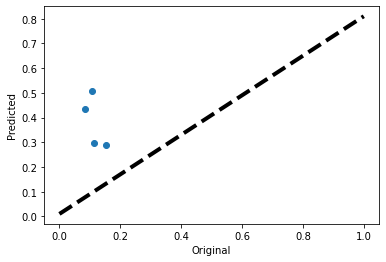

In [22]:
fig, ax = pyplot.subplots()
ax.scatter(test_y_S1, predicted)
ax.plot([test_y.min(), test_y.max()], 'k--', lw=4)
ax.set_xlabel('Original')
ax.set_ylabel('Predicted')

<br>

As a final step, you can calculate the `Pearson correlation coefficient` between original (to-predict) and predicted soil moisture values. The coefficient value can range between `[-1,1]` and is a measure about the strength of the correlation between original and predicted soil moisture.

In [22]:
test_y_nparray = np.array(test_y_S1)
test_y_flattened = test_y_nparray.flatten()
predicted_nparray = np.array(predicted)
predicted_flattened = predicted_nparray.flatten()

corr, _ = scipy.stats.pearsonr(test_y_flattened, predicted_flattened)
print('Pearson correlation: %.3f' % corr)

Pearson correlation: -0.763


<br>

<a href="https://www.futurelearn.com/courses/artificial-intelligence-for-earth-monitoring/1/steps/1170987"><< Back to FutureLearn</a><br>

<hr>

<img src='../../img/copernicus_logo.png' alt='Copernicus logo' align='left' width='20%'></img>

Course developed for [EUMETSAT](https://www.eumetsat.int/), [ECMWF](https://www.ecmwf.int/) and [Mercator Ocean International](https://www.mercator-ocean.fr/en/) in support of the [EU’s Copernicus Programme](https://www.copernicus.eu/en) and the [WEkEO platform](https://wekeo.eu/).
